## Atuação de redes neurais na base de dados do ENEM.

##### Alunos:

-   Gabriel Fonseca (2111066)
-   Yasmim Santos (2116925)
-   Alejandro Elias (2111189)
-   Pedro Lucas (2111131)

Base de dados escolhida - Exame Nacional do Ensino Médio (Enem): https://basedosdados.org/dataset/3e9c8804-c31c-4f48-9a45-d67f1c21a859


In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.utils import to_categorical

In [69]:
df_enem = pd.read_csv("../data/out/enem-dados-tratados-ml.csv")

tts_r_state = 73
mlp_r_state = 83

X = df_enem.drop("label", axis=1).to_numpy()
y = df_enem["label"]

num_classes = len(y.unique())

y = y.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=tts_r_state
)

n_components = X.shape[1]

y_train_keras = to_categorical(y_train, num_classes=num_classes)
y_test_keras = to_categorical(y_test, num_classes=num_classes)

df_enem

,pc1,pc2,label
0,0.080772,-0.762079,0
1,-0.393376,-0.548345,3
2,0.776151,0.015065,4
3,-0.298046,-0.212123,3
4,-0.112868,-0.191354,0
...,...,...,...
176574,0.690036,0.275452,4
176575,-0.864845,0.316927,1
176576,-0.690968,-0.464807,3
176577,-0.095766,-0.509823,0


In [70]:
def plot_confusion_matrix(y_true, y_pred, modelo, cmap):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, cbar=False)
    plt.xlabel("Classe predita")
    plt.ylabel("Classe verdadeira")
    plt.title(f"Matriz de confusão ({modelo})")
    plt.show()


def plot_clusters(X_test, y_pred, modelo, cmap):
    fig, ax = plt.subplots()
    fig.set_size_inches(7, 7)
    scatter = ax.scatter(
        X_test[:, 0],
        X_test[:, 1],
        c=y_pred,
        cmap=cmap,
        edgecolors="k",
    )
    legend = ax.legend(*scatter.legend_elements(), title="Classes")
    ax.add_artist(legend)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(f"Clusters ({modelo})")
    plt.show()


def class_grid_search(
    model: BaseEstimator,
    param_grid: dict,
    X_train: np.ndarray,
    y_train: np.ndarray,
    n_components: int,
):
    model_name = model.__class__.__name__.lower()

    grid_search = GridSearchCV(model, param_grid, n_jobs=-1, cv=5, scoring="accuracy")
    grid_search.fit(X_train, y_train)

    resultado_gs = pd.DataFrame(grid_search.cv_results_)
    resultado_gs = resultado_gs.sort_values(by="rank_test_score")

    resultado_gs.to_csv(
        f"../data/out/resultado_gridsearch_{model_name}_{n_components}.csv", index=False
    )

    resultado_gs = resultado_gs[
        ["params", "mean_test_score", "std_test_score", "rank_test_score"]
    ]

    return resultado_gs

1. ~~Diminuir o número de epocas~~
2. ~~Variar o batch size~~
3. ~~Testar outro modelo sem ser de deep learning~~
4. ~~Testar a variação das camadas ocultas utilizando tensorflow e colocando a função de ativação softmax na camada de saida~~


In [72]:
model = Sequential(
    [
        Input(shape=(X_train.shape[1],)),
        Dense(64, activation="relu"),
        Dense(32, activation="relu"),
        Dense(16, activation="relu"),
        Dense(5, activation="softmax"),
    ]
)

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
history = model.fit(
    X_train,
    y_train_keras,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
)
test_loss, test_accuracy = model.evaluate(X_test, y_test_keras)

mlp_tf_accuracy = f"{test_accuracy:.2%}"

print(f"Test accuracy: {test_accuracy:.2%}")

Epoch 1/10


2208/2208 ━━━━━━━━━━━━━━━━━━━━ 3s 851us/step - accuracy: 0.9442 - loss: 0.2905 - val_accuracy: 0.9970 - val_loss: 0.0119
Epoch 2/10
2208/2208 ━━━━━━━━━━━━━━━━━━━━ 2s 796us/step - accuracy: 0.9960 - loss: 0.0107 - val_accuracy: 0.9889 - val_loss: 0.0284
Epoch 3/10
2208/2208 ━━━━━━━━━━━━━━━━━━━━ 2s 846us/step - accuracy: 0.9962 - loss: 0.0090 - val_accuracy: 0.9962 - val_loss: 0.0089
Epoch 4/10
2208/2208 ━━━━━━━━━━━━━━━━━━━━ 2s 848us/step - accuracy: 0.9970 - loss: 0.0077 - val_accuracy: 0.9973 - val_loss: 0.0062
Epoch 5/10
2208/2208 ━━━━━━━━━━━━━━━━━━━━ 2s 947us/step - accuracy: 0.9969 - loss: 0.0079 - val_accuracy: 0.9986 - val_loss: 0.0049
Epoch 6/10
2208/2208 ━━━━━━━━━━━━━━━━━━━━ 2s 801us/step - accuracy: 0.9973 - loss: 0.0063 - val_accuracy: 0.9963 - val_loss: 0.0072
Epoch 7/10
2208/2208 ━━━━━━━━━━━━━━━━━━━━ 2s 768us/step - accuracy: 0.9973 - loss: 0.0066 - val_accuracy: 0.9973 - val_loss: 0.0052
Epoch 8/10
2208/2208 ━━━━━━━━━━━━━━━━━━━━ 2s 764us/step - accuracy: 0.9974 - loss: 0.00

2760/2760 ━━━━━━━━━━━━━━━━━━━━ 2s 567us/step


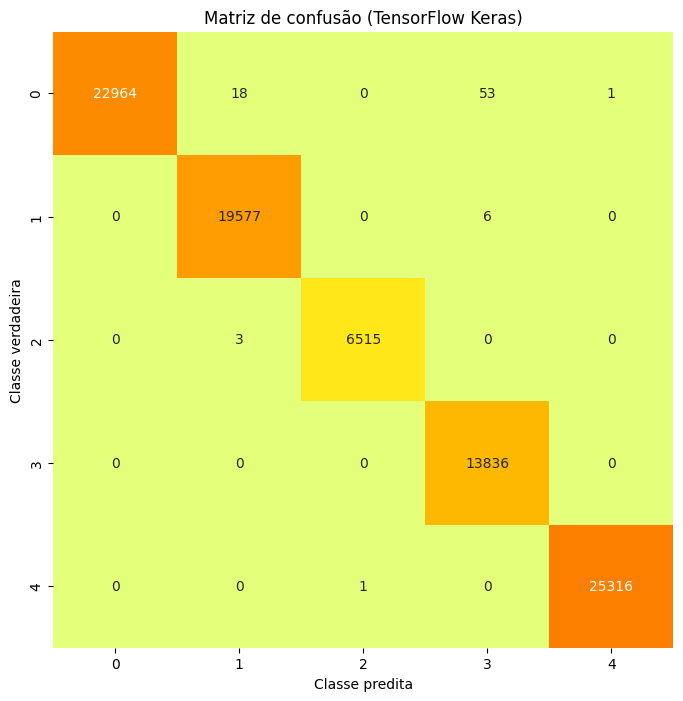

In [73]:
y_pred = model.predict(X_test).argmax(axis=1)

plot_confusion_matrix(y_test, y_pred, "TensorFlow Keras", "Wistia")

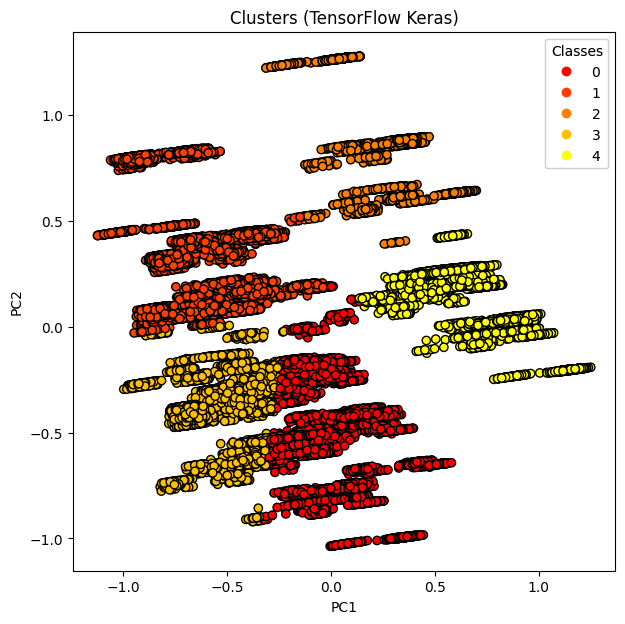

In [74]:
plot_clusters(X_test, y_pred, "TensorFlow Keras", "autumn")

In [75]:
perceptron = Perceptron(random_state=mlp_r_state)

param_grid = {
    "penalty": [None, "l2", "l1", "elasticnet"],
    "alpha": [1e-4, 1e-3, 1e-2, 1e-1],
    "fit_intercept": [True, False],
    "max_iter": [1000, 2000, 3000],
    "tol": [1e-3, 1e-4, 1e-5],
    "shuffle": [True, False],
    "eta0": [1.0, 0.1, 0.01],
    "early_stopping": [True, False],
    "validation_fraction": [0.1, 0.2, 0.3],
}

class_grid_search(perceptron, param_grid, X_train, y_train, n_components)

In [76]:
mlp = MLPClassifier(random_state=mlp_r_state)

param_grid = {
    "hidden_layer_sizes": [(50,), (100,), (50, 50)],
    "activation": ["tanh", "relu"],
    "solver": ["adam"],
    "alpha": [1e-4, 1e-3],
    "learning_rate": ["constant", "adaptive"],
    "batch_size": [16, 32, 64],
    "max_iter": [30, 60, 90],
}

class_grid_search(mlp, param_grid, X_train, y_train, n_components)

In [77]:
# perceptron_params = {
#     "alpha": 0.0001,
#     "early_stopping": False,
#     "eta0": 0.1,
#     "fit_intercept": False,
#     "max_iter": 3000,
#     "penalty": "l1",
#     "shuffle": True,
#     "tol": 1e-05,
#     "validation_fraction": 0.3,
# }

# perceptron = Perceptron(**perceptron_params)

# perceptron.fit(X_train, y_train)
# test_accuracy = perceptron.score(X_test, y_test)

# test_accuracy

In [78]:
mlp_params = {
    "activation": "tanh",
    "alpha": 0.001,
    "batch_size": 16,
    "hidden_layer_sizes": (100,),
    "learning_rate": "constant",
    "max_iter": 30,
    "solver": "adam",
}

mlp = MLPClassifier(random_state=mlp_r_state)
mlp.fit(X_train, y_train)
test_accuracy = mlp.score(X_test, y_test)

y_pred = mlp.predict(X_test)

mlp_sk_accuracy = f"{test_accuracy:.2%}"

print(f"Test accuracy: {test_accuracy:.2%}")

Test accuracy: 99.93%


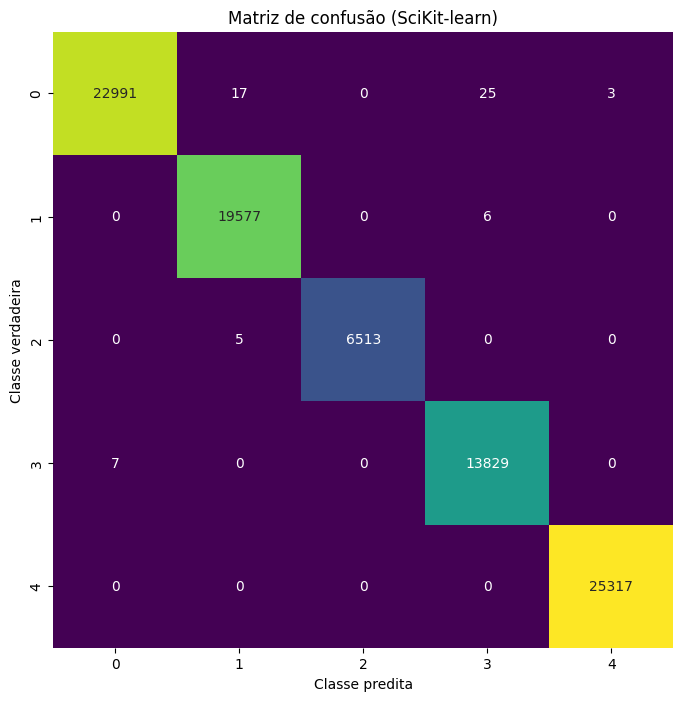

In [79]:
plot_confusion_matrix(y_test, y_pred, "SciKit-learn", "viridis")

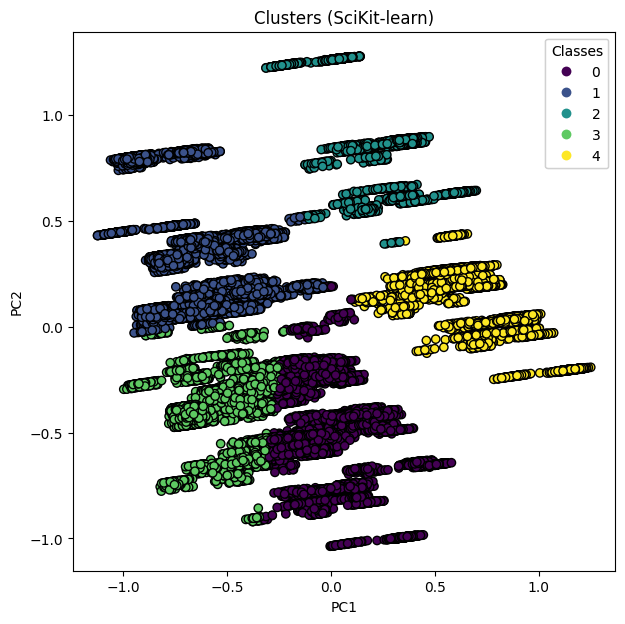

In [80]:
plot_clusters(X_test, y_pred, "SciKit-learn", "viridis")

In [81]:
pd.DataFrame(
    {
        "Modelo": ["TensorFlow Keras", "SciKit-learn"],
        "Acurácia": [mlp_tf_accuracy, mlp_sk_accuracy],
    }
)

,Modelo,Acurácia
0,TensorFlow Keras,99.91%
1,SciKit-learn,99.93%
